# Combatting overfitting through data augmentation and dropout regularisation

Import dependencies from prev steps

In [2]:
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import numpy as np
from matplotlib import pyplot as plt

Import and initialise our unaugmented data first

In [3]:
# setup general info on batch sizes and img sizes
batch_size = 32
img_height = 256
img_width = 256

In [4]:
# generate training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    "Cars",
    validation_split= 0.2, # let the program know what the validation split will be in order to choose the correct size of this training set as well
    subset="training", # here we denote that this set will be the *training* set.
    seed=123,
    image_size = (img_height, img_width), # rescale images automatically
    batch_size= batch_size
) 

Found 3697 files belonging to 5 classes.
Using 2958 files for training.


In [5]:
# generate validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    "Cars",
    validation_split= 0.2,
    subset="validation", # here we denote that this set will be the *validation* set.
    seed=123, 
    image_size = (img_height, img_width),
    batch_size= batch_size
)

Found 3697 files belonging to 5 classes.
Using 739 files for validation.


In [6]:
# automatic labelling with this object, based on dict names.
class_names = train_ds.class_names

In [7]:
# taken from tf tutorial, unknown what this does so far
AUTOTUNE = tf.data.AUTOTUNE

# randomly shuffle your data.
train_ds_pref = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# function of this line is currently unknown.
val_ds_pref = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data augmentation

Now that we've imported the initial data, we can perform the actual data augmentation.

In [8]:
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom

In [9]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Let's visualise an example:

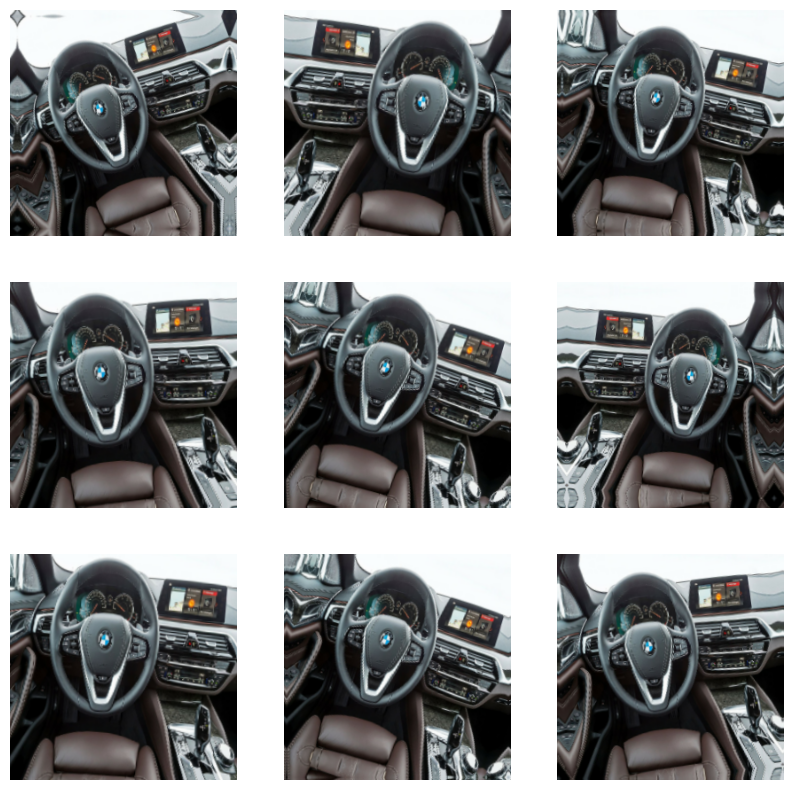

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

With this function in place, we can generate a much larger dataset for our network to train on. Since larger $N_{data}$ is always better, this will of course improve performance.

## Dropout regularisation

However, generally, overfitting is tackled using also *regularisation*. For this, TF recommends [*dropout*](https://www.youtube.com/watch?v=NhZVe50QwPM), a rather new regularisation technique in which for each training sample, a number of activations are (at random) turned off completely. This forces the network to never be able to rely on one single activation, as it may be turned off at any point, and thus it must make a number of 'redundant' ways of classifying images. While this at first seems highly inefficient, it forces the network to get anwsers based on the 'consensus' of multiple activations, making the network generally more robust and much less prone to overfit.

In [11]:
from tensorflow.keras.layers import Dropout

With all this included, our new model looks like this:

In [12]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation, # data augmentation as a very first step
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), # here we perform the dropout.
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [13]:
# compile the model
model.compile(optimizer='adam', # choose the optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function is same as error function
              metrics=['accuracy']) # choose which metrics to keep track of during optimization

In [14]:
# provide overview of the model dataflow
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                 

In [28]:
epochs = 30
history = model.fit(
  train_ds_pref,
  validation_data=val_ds_pref,
  epochs=epochs
)

Epoch 1/30


93/93 [==============================] - 63s 680ms/step - loss: 0.9823 - accuracy: 0.6116 - val_loss: 1.5859 - val_accuracy: 0.4966
Epoch 2/30
93/93 [==============================] - 64s 686ms/step - loss: 0.9215 - accuracy: 0.6521 - val_loss: 1.3432 - val_accuracy: 0.5101
Epoch 3/30
93/93 [==============================] - 61s 652ms/step - loss: 0.9198 - accuracy: 0.6464 - val_loss: 1.3356 - val_accuracy: 0.5291
Epoch 4/30
93/93 [==============================] - 61s 654ms/step - loss: 0.8685 - accuracy: 0.6758 - val_loss: 1.6254 - val_accuracy: 0.4844
Epoch 5/30
93/93 [==============================] - 60s 647ms/step - loss: 0.8622 - accuracy: 0.6846 - val_loss: 1.5380 - val_accuracy: 0.5196
Epoch 6/30
93/93 [==============================] - 61s 654ms/step - loss: 0.8567 - accuracy: 0.6744 - val_loss: 1.4086 - val_accuracy: 0.5250
Epoch 7/30
93/93 [==============================] - 60s 644ms/step - loss: 0.8287 - accuracy: 0.6859 - val_loss: 1.6476 - val_accuracy: 0.5277
Epoch 8/30

In [29]:
def plot_results(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

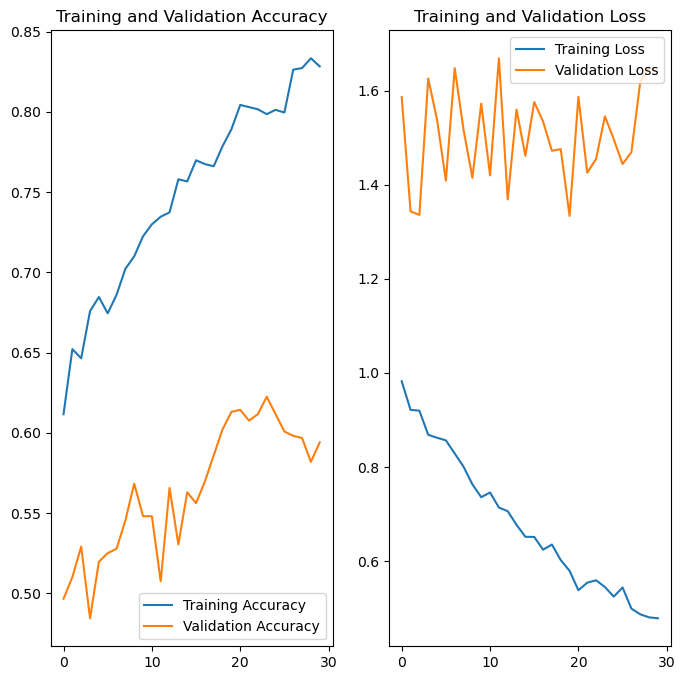

In [30]:
# plot the training results
plot_results(history)

In [20]:
model_lowdropout = Sequential([
  data_augmentation, # data augmentation as a very first step
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.05), # here we perform the dropout.
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [21]:
# compile the model
model_lowdropout.compile(optimizer='adam', # choose the optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function is same as error function
              metrics=['accuracy']) # choose which metrics to keep track of during optimization

In [22]:
epochs = 15
history_lowdropout = model_lowdropout.fit(
  train_ds_pref,
  validation_data=val_ds_pref,
  epochs=epochs
)

Epoch 1/15
93/93 [==============================] - 64s 677ms/step - loss: 1.6663 - accuracy: 0.2718 - val_loss: 1.5956 - val_accuracy: 0.2693
Epoch 2/15
93/93 [==============================] - 61s 659ms/step - loss: 1.5839 - accuracy: 0.2789 - val_loss: 1.5734 - val_accuracy: 0.2774
Epoch 3/15
93/93 [==============================] - 60s 650ms/step - loss: 1.5616 - accuracy: 0.2972 - val_loss: 1.5689 - val_accuracy: 0.2882
Epoch 4/15
93/93 [==============================] - 60s 646ms/step - loss: 1.5484 - accuracy: 0.3046 - val_loss: 1.5764 - val_accuracy: 0.2774
Epoch 5/15
93/93 [==============================] - 60s 644ms/step - loss: 1.5423 - accuracy: 0.3070 - val_loss: 1.5658 - val_accuracy: 0.3112
Epoch 6/15
93/93 [==============================] - 60s 644ms/step - loss: 1.5169 - accuracy: 0.3293 - val_loss: 1.5514 - val_accuracy: 0.3099
Epoch 7/15
93/93 [==============================] - 60s 648ms/step - loss: 1.4872 - accuracy: 0.3570 - val_loss: 1.6138 - val_accuracy: 0.2909

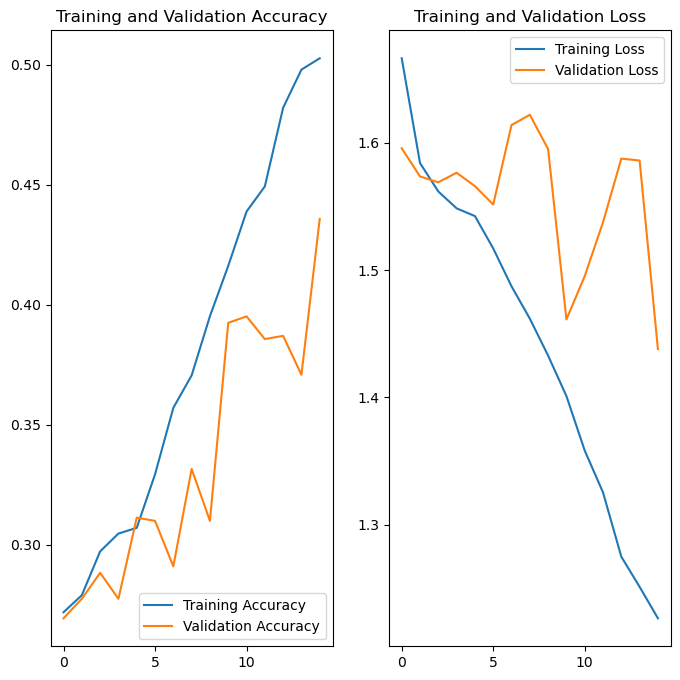

In [23]:
# plot the training results
plot_results(history_lowdropout)

In [24]:
model_highdropout = Sequential([
  data_augmentation, # data augmentation as a very first step
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.5), # here we perform the dropout.
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

In [25]:
# compile the model
model_highdropout.compile(optimizer='adam', # choose the optimizer
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # loss function is same as error function
              metrics=['accuracy']) # choose which metrics to keep track of during optimization

In [26]:
epochs = 15
history_highdropout = model_highdropout.fit(
  train_ds_pref,
  validation_data=val_ds_pref,
  epochs=epochs
)

Epoch 1/15
93/93 [==============================] - 62s 650ms/step - loss: 1.6204 - accuracy: 0.2606 - val_loss: 1.5929 - val_accuracy: 0.2760
Epoch 2/15
93/93 [==============================] - 60s 642ms/step - loss: 1.5852 - accuracy: 0.2863 - val_loss: 1.6009 - val_accuracy: 0.2124
Epoch 3/15
93/93 [==============================] - 60s 641ms/step - loss: 1.5783 - accuracy: 0.2799 - val_loss: 1.5883 - val_accuracy: 0.2869
Epoch 4/15
93/93 [==============================] - 60s 647ms/step - loss: 1.5603 - accuracy: 0.2904 - val_loss: 1.5850 - val_accuracy: 0.2693
Epoch 5/15
93/93 [==============================] - 59s 636ms/step - loss: 1.5547 - accuracy: 0.2948 - val_loss: 1.5665 - val_accuracy: 0.2950
Epoch 6/15
93/93 [==============================] - 59s 635ms/step - loss: 1.5350 - accuracy: 0.3114 - val_loss: 1.5536 - val_accuracy: 0.3031
Epoch 7/15
93/93 [==============================] - 59s 636ms/step - loss: 1.5336 - accuracy: 0.3049 - val_loss: 1.5496 - val_accuracy: 0.3045

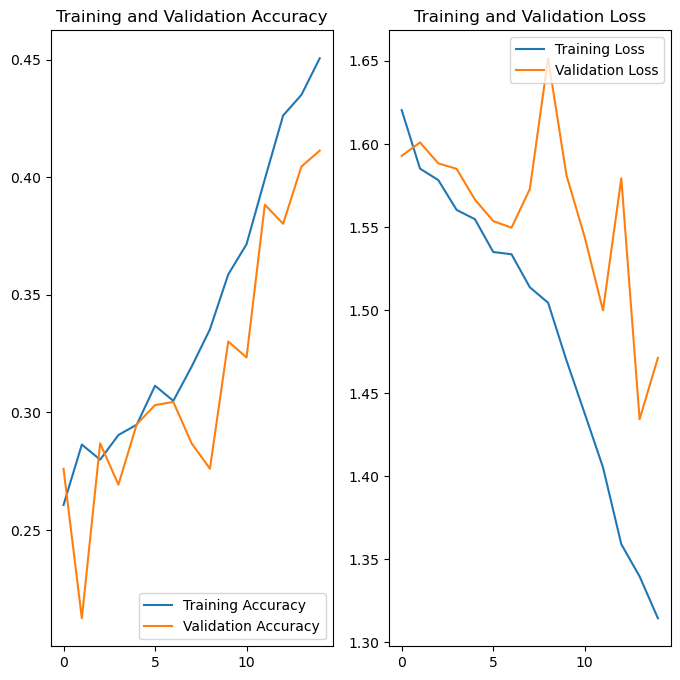

In [27]:
# plot the training results
plot_results(history_highdropout)